In [1]:
from matplotlib import rcParams
import torch
from typing import Any, List, Sequence, Union
import yaml

# Local imports
from function_definitions import f, u
from Utils.Types.Grid import construct_grid, Grid
from Utils.Types.DataSet import DataSet
from Utils.test_functions import evaluate_test_funcs
from Utils.utils import integrate
import Utils.Plots as Plots
from Utils.utils import validate_cfg
from Utils.VPINN import VPINN

In [2]:
# Specify device used to train. Default is the gpu, but torch falls back on the cpu in case cuda is unavailable
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load config file
with open('config.yml', 'r') as file:
    cfg = yaml.safe_load(file)

In [4]:
# Validate the configuration to prevent cryptic errors
validate_cfg(cfg)

# Get space parameters from the config
dim: int = cfg['space']['dimension']
eq_type: str = cfg['PDE']['type']
var_form: int = cfg['variational_form']
grid_size: Union[int, Sequence[int]] = cfg['space']['grid_size']['x'] if dim == 1 else [
    cfg['space']['grid_size']['x'], cfg['space']['grid_size']['y']]
grid_boundary: Sequence = cfg['space']['boundary']['x'] if dim == 1 else [cfg['space']['boundary']['x'],
                                                                          cfg['space']['boundary']['y']]

# Get the neural net architecture from the config
n_nodes: int = cfg['architecture']['nodes_per_layer']
n_layers: int = cfg['architecture']['layers']
architecture: Union[List[int], Any] = [dim] + [n_nodes] * (n_layers + 1) + [1]

# Get PDE constants from the config
PDE_constants: dict = {'Helmholtz': cfg['PDE']['Helmholtz']['k'],
                       'Burger': cfg['PDE']['Burger']['nu']}

# Get number of test functions in each dimension
test_func_dim: Union[int, Sequence[int]] = cfg['N_test_functions']['x'] if dim == 1 else [
    cfg['N_test_functions']['x'], cfg['N_test_functions']['y']]
n_test_funcs: int = test_func_dim if dim == 1 else test_func_dim[0] * test_func_dim[1]

In [5]:
# Construct the grid
print("Constructing grid ...")
grid: Grid = construct_grid(dim, grid_boundary, grid_size, as_tensor=True, requires_grad=False)

Constructing grid ...


In [6]:
# Evaluate the test functions on grid points.
print("Evaluating test functions on the grid interior ... ")
test_func_vals, idx = evaluate_test_funcs(grid, test_func_dim)
d1test_func_vals = evaluate_test_funcs(grid, test_func_dim, d=1, output_dim=2)[0] if var_form == 1 else None
d2test_func_vals = evaluate_test_funcs(grid, test_func_dim, d=2, output_dim=2)[0] if var_form == 2 else None

Evaluating test functions on the grid interior ... 


In [7]:
# Integrate the external function over the grid against all the test functions.
# This will be used to calculate the variational loss; this step is costly and only needs to be done once.
print("Integrating test functions ...")
f_integrated: DataSet = DataSet(coords=idx,
                                data=[integrate(f(grid.interior), test_func_vals[i], grid.volume)
                                      for i in range(n_test_funcs)], as_tensor=True, requires_grad=False)

Integrating test functions ...


In [8]:
# Instantiate the model class
model: VPINN = VPINN(architecture, eq_type, var_form,
                     pde_constants=PDE_constants,
                     learning_rate=cfg['learning_rate'],
                     activation_func=torch.sin).to(device)

In [9]:
# Turn on tracking for the grid interior, on which the variational loss is calculated
grid.boundary.requires_grad = True
grid.interior.requires_grad = True

In [10]:
# Prepare the training data. The training data consists of the explicit solution of the function on the boundary.
# For the Burger's equation, initial data is only given on the lower spacial boundary.
print("Generating training data ...")
if eq_type == 'Burger':
    lower_boundary = torch.reshape(torch.tensor(list(zip(grid.x, torch.zeros(len(grid.x))))), (len(grid.x), 2))
    training_data: DataSet = DataSet(coords=lower_boundary, data=u(lower_boundary), as_tensor=True,
                                     requires_grad=False)
else:
    training_data: DataSet = DataSet(coords=grid.boundary, data=u(grid.boundary), as_tensor=True, requires_grad=False)

Generating training data ...


In [11]:
# Train the model
print("Commencing training ...")
b_weight, v_weight = cfg['boundary_loss_weight'], cfg['variational_loss_weight']

for it in range(cfg['N_iterations'] + 1):

    model.optimizer.zero_grad()

    # Calculate the loss
    loss_b = model.boundary_loss(training_data)
    loss_v = model.variational_loss(grid, f_integrated, test_func_vals, d1test_func_vals, d2test_func_vals)
    loss = v_weight * loss_v + b_weight * loss_b
    loss.backward()

    # Adjust the model parameters
    model.optimizer.step()

    # Track loss values
    loss_glob, loss_b_glob, loss_v_glob = loss.item(), loss_b.item(), loss_v.item()

    if it % 10 == 0:
        model.update_loss_tracker(it, loss_glob, loss_b_glob, loss_v_glob)
    if it % 100 == 0:
        print(f"Iteration {it}: total loss: {loss_glob}, loss_b: {loss_b_glob}, loss_v: {loss_v_glob}")

    del loss

print("Training complete.")

Commencing training ...
Iteration 0: total loss: 0.978615403175354, loss_b: 4.771267413161695e-05, loss_v: 0.9784722924232483
Iteration 100: total loss: 0.9744548201560974, loss_b: 0.0011144222225993872, loss_v: 0.971111536026001
Iteration 200: total loss: 0.9071997404098511, loss_b: 0.010809713043272495, loss_v: 0.8747705817222595
Iteration 300: total loss: 0.6163709759712219, loss_b: 0.0053173513151705265, loss_v: 0.6004189252853394
Iteration 400: total loss: 0.4942706525325775, loss_b: 0.0057623074389994144, loss_v: 0.4769837260246277
Iteration 500: total loss: 0.4769652485847473, loss_b: 0.006046044174581766, loss_v: 0.45882710814476013
Iteration 600: total loss: 0.4655109941959381, loss_b: 0.006421559490263462, loss_v: 0.44624632596969604
Iteration 700: total loss: 0.45830702781677246, loss_b: 0.006605895701795816, loss_v: 0.4384893476963043
Iteration 800: total loss: 0.45429670810699463, loss_b: 0.006893212907016277, loss_v: 0.4336170554161072
Iteration 900: total loss: 0.4514627

In [12]:
# Plot the results
print("Plotting ... ")
rcParams.update(cfg['plots']['rcParams'])

# Generate the plot grid, which may be finer than the training grid
plot_res = cfg['plots']['plot_resolution']['x'] if dim == 1 else [cfg['plots']['plot_resolution']['x'],
                                                                  cfg['plots']['plot_resolution']['y']]
plot_grid: Grid = construct_grid(dim, grid_boundary, plot_res, requires_grad=False)

Plotting ... 


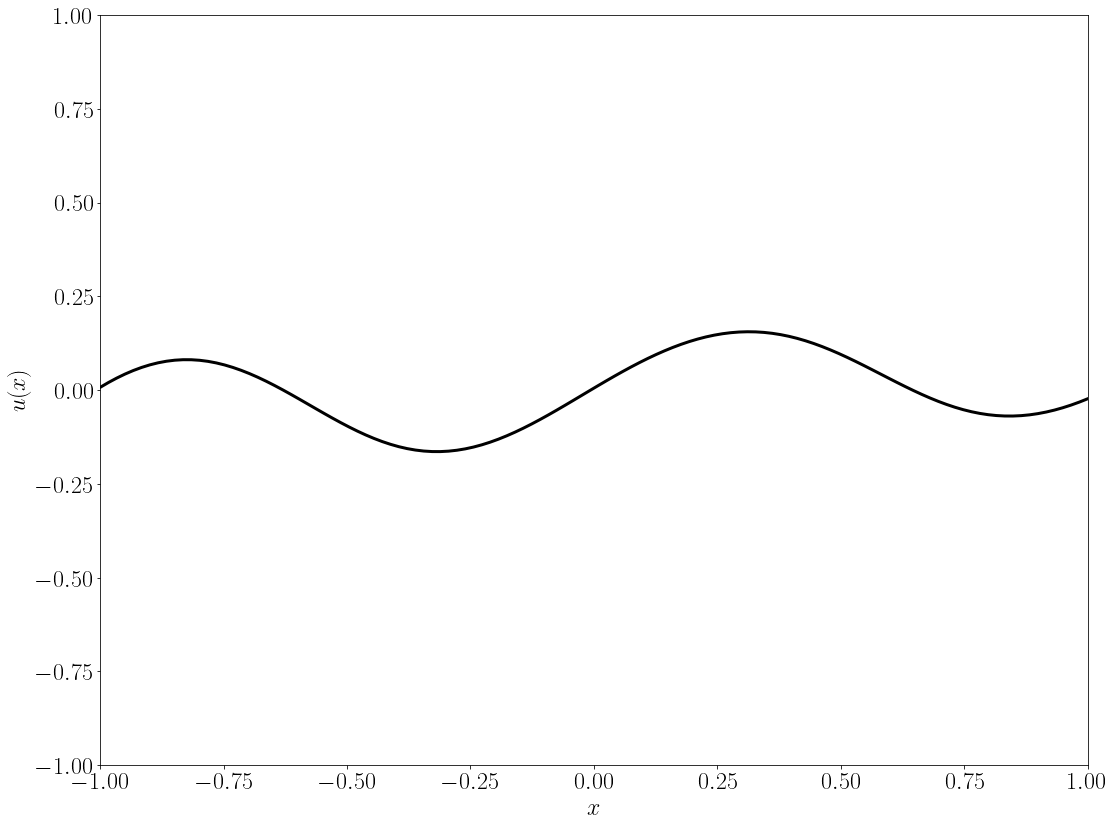

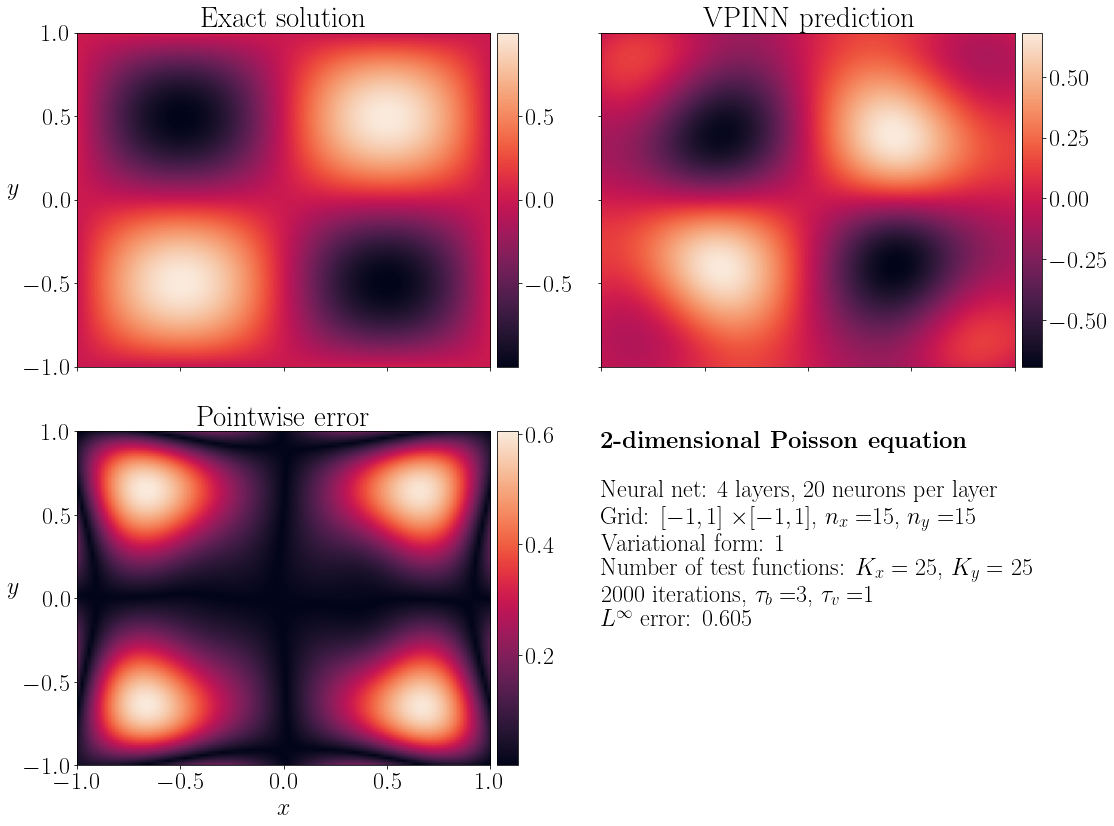

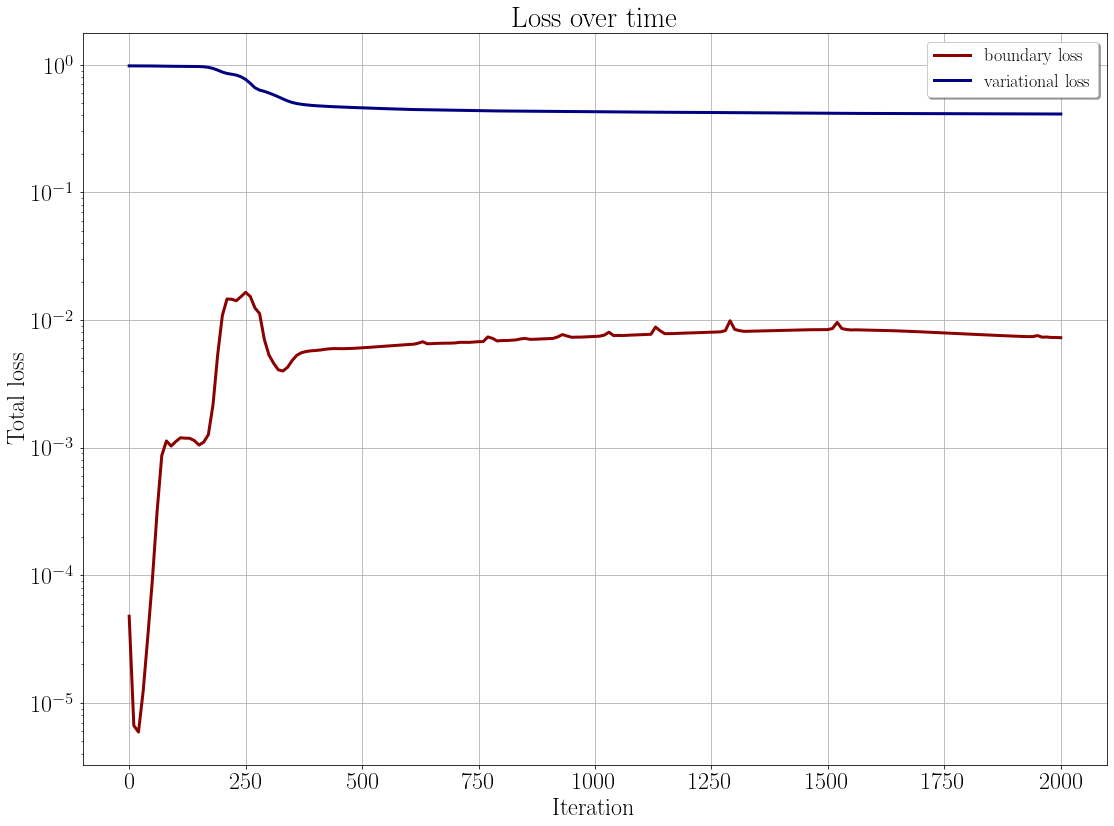

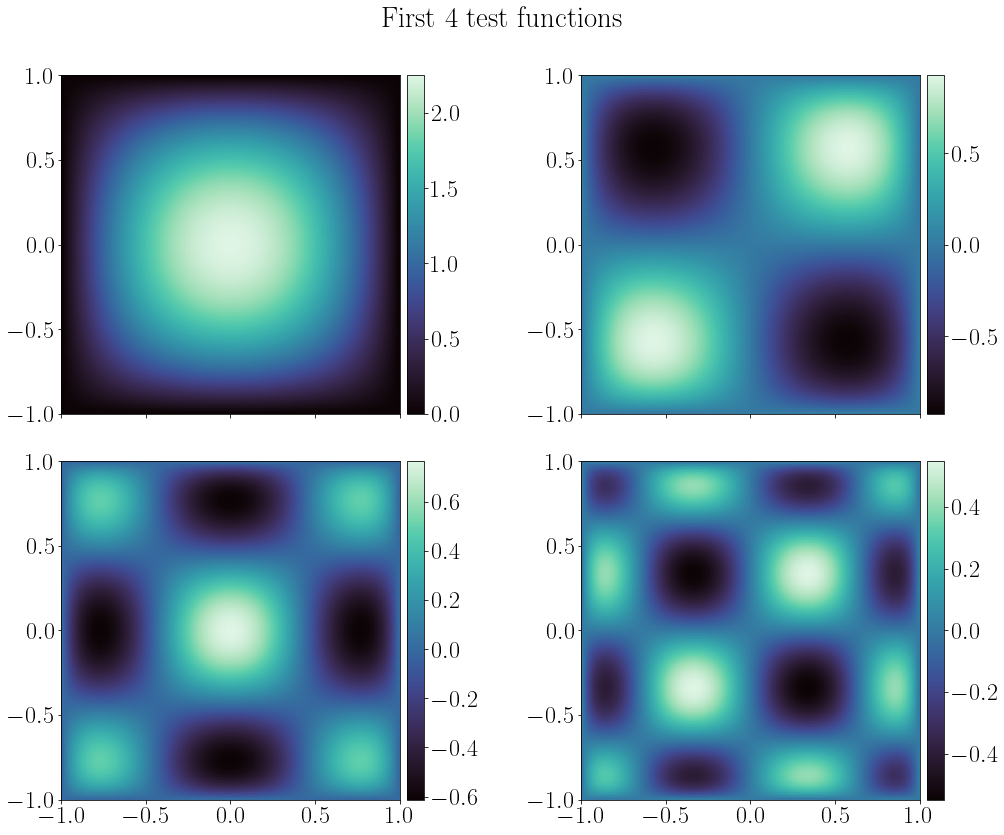

Done.


In [13]:
# Get the model predictions on the plotting grid. Turn off tracking for the prediction data.
predictions = model.forward(plot_grid.data).detach()

# Plot an animation of the predictions
if grid.dim == 2 and cfg['plots']['plot_animation']:
    Plots.animate(plot_grid, predictions, show=True)

# Plot predicted vs actual values
Plots.plot_prediction(cfg, plot_grid, predictions, grid_shape=plot_res, show=True)

# Plot loss over time
Plots.plot_loss(model.loss_tracker, show=True)

# Plot test functions
Plots.plot_test_functions(plot_grid, order=min(4, n_test_funcs), d=0, show=True)

print("Done.")